In [1]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
import cv2
import random

2022-03-16 11:08:10.780304: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Segmentation Models: using `tf.keras` framework.


In [2]:
import os

train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (448, 448)
input_channels = 3
output_channels = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 46839
Number test of samples: 1204
data/train/huawei_raw/0.png | data/train/canon/0.jpg
data/train/huawei_raw/1.png | data/train/canon/1.jpg
data/train/huawei_raw/10.png | data/train/canon/10.jpg
data/train/huawei_raw/100.png | data/train/canon/100.jpg
data/train/huawei_raw/1000.png | data/train/canon/1000.jpg
data/train/huawei_raw/10000.png | data/train/canon/10000.jpg
data/train/huawei_raw/10001.png | data/train/canon/10001.jpg
data/train/huawei_raw/10002.png | data/train/canon/10002.jpg
data/train/huawei_raw/10003.png | data/train/canon/10003.jpg
data/train/huawei_raw/10004.png | data/train/canon/10004.jpg


In [3]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

In [4]:
def extract_bayer_channels(raw):

    # Reshape the input bayer image

    ch_B  = raw[1::2, 1::2]
    ch_Gb = raw[0::2, 1::2]
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[1::2, 0::2]

    RAW_combined = np.dstack((ch_B, ch_Gb, ch_R, ch_Gr))
    RAW_norm = RAW_combined.astype(np.float32) / (4 * 255)

    return RAW_norm

class DataLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + (224, 224) + (12,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = cv2.imread(path)
            x[j] = extract_bayer_channels(img) #np.expand_dims(img[:,:,0], 2)
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = cv2.imread(path)
            y[j] = img[:,:,::-1] / 255.0
        return x, y

In [5]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DataLoader(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DataLoader(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
test_gen = DataLoader(
    batch_size, img_size, test_input_img_paths, test_target_img_paths
)

In [6]:
x, y = train_gen.__getitem__(0)

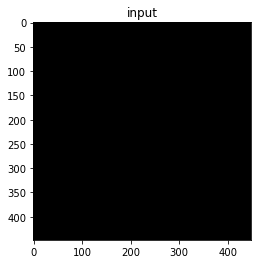

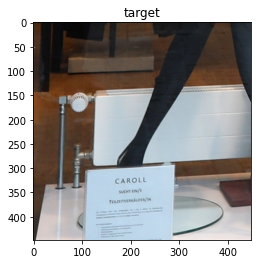

In [22]:
plt_display(x[0], 'input')
plt_display(y[0], 'target')

In [8]:
model = sm.Unet(
    backbone_name='resnet18', 
    encoder_weights='imagenet', 
    input_shape=(224, 224, 12),
    classes=3
)
model.summary()
model.compile(optimizer="adam", loss='mae')

2022-03-14 12:05:50.514186: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-14 12:05:50.516272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-14 12:05:50.549385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 12:05:50.549513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-14 12:05:50.549522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-14 12:05:50.550324: I tensorflow/stream_executor/platfor

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 448, 448, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 454, 454, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 224, 224, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [9]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2022-03-14 12:06:00.082390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-14 12:06:00.101923: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3793140000 Hz


Epoch 1/3


2022-03-14 12:06:01.335682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-14 12:06:01.874984: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-14 12:06:01.920340: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-03-14 12:06:02.237715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2864/2864 [==============================] - 727s 243ms/step - loss: 0.1712 - val_loss: 0.3287
Epoch 2/3
2864/2864 [==============================] - 696s 243ms/step - loss: 0.1547 - val_loss: 0.2173
Epoch 3/3
2864/2864 [==============================] - 696s 243ms/step - loss: 0.1510 - val_loss: 0.3051


In [10]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)

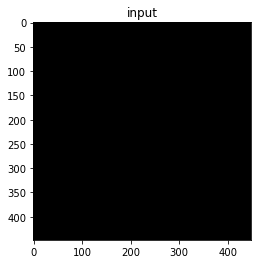

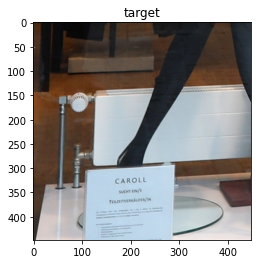

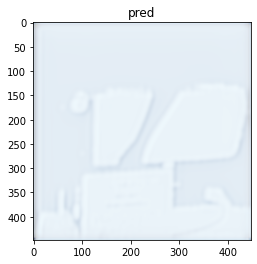

In [12]:
plt_display(x[0], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'pred')

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D

def get_unet(img_rows, img_cols): 
    inputs = Input(shape=(img_rows, img_cols, 12))
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    up10 = Convolution2D(16, (2, 2),activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv9))
    conv10 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv10)

    conv11 = Convolution2D(3, (1, 1), activation='sigmoid')(conv10)
    model = Model(inputs=inputs, outputs=conv11)
    return model

In [13]:
def ssim_loss(y_true, y_pred):
    return tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)

def psnr_loss(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + psnr_loss(y_true, y_pred)


In [14]:
model = get_unet(224, 224)
model.summary()
model.compile(optimizer="adam", loss=main_loss)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 12 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 224, 224, 32) 3488        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_53[0][0]                  
____________________________________________________________________________________________

In [ ]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

 936/2864 [========>.....................] - ETA: 6:28 - loss: 5.6327

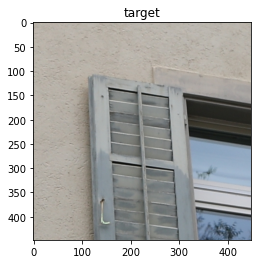

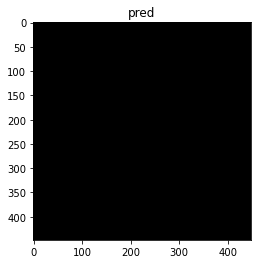

In [16]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)
#plt_display(x[0][:,:,0], 'input')
plt_display(y[1], 'target')
plt_display(preds[1], 'pred')

In [26]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 - 1:size//2 + 1, -size//2 - 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)


def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1.0  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2.0*mu1_mu2 + C1)*(2.0*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2.0*mu1_mu2 + C1)*(2.0*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

In [35]:
tf.reduce_mean(tf.image.ssim(y[1], preds[3], max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.19614655>

In [27]:
tf_ssim(y[1], preds[3])

2022-03-16 11:03:32.744613: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at conv_ops.cc:529 : Invalid argument: input must be 4-dimensional[448,448,3]


InvalidArgumentError: input must be 4-dimensional[448,448,3] [Op:Conv2D]

In [30]:
tf.image.ssim_multiscale(
        y[1], preds[3], 1.0
)


<tf.Tensor: shape=(), dtype=float32, numpy=0.15030637>

In [23]:
tf.keras.losses.mean_absolute_error(y[1][:,:,1], preds[3][:,:,1])

<tf.Tensor: shape=(448,), dtype=float32, numpy=
array([0.70438546, 0.7056285 , 0.7071604 , 0.7077643 , 0.70872724,
       0.7094626 , 0.70794815, 0.7078606 , 0.7084471 , 0.7063025 ,
       0.70467436, 0.7043505 , 0.70438546, 0.70557594, 0.70648634,
       0.7034839 , 0.7031425 , 0.7044205 , 0.704333  , 0.70484954,
       0.70456934, 0.702022  , 0.70104164, 0.7006478 , 0.70265234,
       0.7039128 , 0.7057161 , 0.7057949 , 0.7062588 , 0.70505947,
       0.7037465 , 0.70446426, 0.70694155, 0.70542717, 0.70182073,
       0.7006215 , 0.70052516, 0.70052516, 0.7011467 , 0.70353645,
       0.7038778 , 0.7033089 , 0.70197827, 0.7008491 , 0.7008491 ,
       0.7013393 , 0.70038515, 0.69980747, 0.69958866, 0.69864327,
       0.6984769 , 0.69938725, 0.70087534, 0.6997811 , 0.69706756,
       0.6960784 , 0.6955357 , 0.6938901 , 0.6931986 , 0.69403017,
       0.69612217, 0.69610465, 0.69655114, 0.69781166, 0.69743526,
       0.6960347 , 0.6951768 , 0.6953694 , 0.69687504, 0.6985032 ,
       0.69899

In [25]:
y[1][:,:,1].shape

(448, 448)